In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt

In [3]:
data_dir = "./data/WASP-77Ab"
# data = h5py.File("../hdf5_experiments/data/WASP-121b.h5", "r")
# os.makedirs("./data/WASP-121b/", exist_ok=True)
# for key in data.keys():
#     os.makedirs(f"./data/WASP-121b/{key}", exist_ok=True)
#     with h5py.File(f"./data/WASP-121b/{key}/data_raw.hdf5", "a") as f:
#         f.create_dataset("wl_grid", data=data[key]["wl_grid"])
#         f.create_dataset("phi", data=data[key]["phi"])
#         f.create_dataset("flux", data=data[key]["flux"])
#         f.create_dataset("transit_weight", data=data[key]["transit_weight"])

#     with h5py.File(f"./data/WASP-121b/{key}/data_processed.hdf5", "a") as f:
#         f.create_dataset("uncertainties_processed", data=data[key]["uncertainties"])
#         f.create_dataset("Bs", data=data[key]["Bs"])
#         f.create_dataset("residuals", data=data[key]["residuals"])
#         f.create_dataset("flux_blaze_corrected", data=data[key]["flux_blaze_corrected"])
#         f.create_dataset("uncertainties", data=data[key]["uncertainties"])
#         f.create_dataset("transit_weight", data=data[key]["transit_weight"])
#         f.create_dataset("wl_grid", data=data[key]["wl_grid"])
#         f.create_dataset("phi", data=data[key]["phi"])

In [4]:
from POSEIDON.utility import read_high_res_data_deprecate

name = "IGRINS"
data = read_high_res_data_deprecate(
    "../high_res_experiments/data/WASP-77Ab/",
    method="pca",
    spectrum_type="emission",
)
flux = data["data_scale"] + data["data_arr"]
wl_grid = data["wl_grid"][:]
phi = data["phi"]
V_bary = data["V_bary"]
flux = remove_outliers(wl_grid, flux)
add_high_res_data(
    data_dir,
    name,
    flux,
    wl_grid,
    phi,
    overwrite=False,
)

30725 outliers removed from a total of 6423648 pixels
Raw data file already exists. Choose another name for observation or set overwrite=True to continue.


In [5]:
# prepare_high_res_data(
#     data_dir,
#     name,
#     "emission",
#     "sysrem_2022",
#     stack_order=False,
#     overwrite=False,
#     Print=True,
#     niter=15,
#     n_PC=5,
# )

In [34]:
from POSEIDON.core import define_model, wl_grid_constant_R

R_s = 0.91 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 0.07 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data_deprecate

# ***** Define model *****#

model_name = "H2O, CO"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["CO"]  # H2O, CO as in Brogi & Line

high_res_params = ["K_p", "V_sys", "log_a"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid
wl = wl_grid_constant_R(wl_min, wl_max, R)

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 400  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -5.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Free parameters: ['a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_CO' 'K_p' 'V_sys'
 'log_a']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO done
Opacity pre-interpolation complete.


In [35]:
# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
    reference_parameter="None",
)

# ***** Specify fixed atmospheric settings for retrieval *****#
# Specify the pressure grid of the atmosphere
P_min = 1.0e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-4]

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array(
    [0.2, 0.1, 0.17, -1.39, 1, 1500]
)  # a1, a2, log_P1, log_P2, log_P3, T_top
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, P_param_set=1e-5
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="direct_emission",
)

In [36]:
def cross_correlate(
    Kp_range, Vsys_range, RV_range, wl, planet_spectrum, data, Print=True
):
    if Print:
        time0 = time.time()
    uncertainties = data["uncertainties_processed"]
    uncertainties = np.ones_like(uncertainties)
    residuals = data["residuals"]
    phi = data["phi"]
    wl_grid = data["wl_grid"]
    # transit_weight = data["transit_weight"]
    # max_transit_depth = np.max(1 - transit_weight)

    norder, nphi, npix = residuals.shape
    CCF_Kp_Vsys = np.zeros((len(Kp_range), len(Vsys_range)))

    nRV = len(RV_range)
    CCF_phase_RV = np.zeros((nphi, nRV))
    models_shifted = np.zeros((nRV, norder, npix))
    for RV_i, RV in enumerate(RV_range):
        # Looping through each order and computing total log-L by summing logLs for each obvservation/order
        for order_i in range(norder):
            wl_slice = wl_grid[order_i]  # Cropped wavelengths
            delta_lambda = RV * 1e3 / constants.c
            wl_shifted = wl * (1.0 + delta_lambda)
            F_p = np.interp(wl_slice, wl_shifted, planet_spectrum)
            models_shifted[RV_i, order_i] = F_p  # choose not to filter

    # negative of transmission spectrum gives absorption. Adding or multiplying constant does not change the CCF
    # m = -models_shifted
    m = models_shifted
    # already minus mean in prepare_data

    for phi_i in range(nphi):
        for RV_i in range(nRV):
            f = residuals[:, phi_i, :]
            CCF = np.sum(f[:, :] * m[RV_i, :, :] / uncertainties[:, phi_i, :] ** 2)
            CCF_phase_RV[phi_i, RV_i] += CCF

    # CCF_phase_RV = (1 - transit_weight[:, None]) * CCF_phase_RV

    for Kp_i, Kp in enumerate(Kp_range):
        for phi_i in range(nphi):
            RV = Kp * np.sin(2 * np.pi * phi[phi_i]) + Vsys_range + V_bary[phi_i]
            CCF_Kp_Vsys[Kp_i] += np.interp(RV, RV_range, CCF_phase_RV[phi_i])
    if Print:
        time1 = time.time()
        print("Cross correlation took {} seconds".format(time1 - time0))
    return CCF_Kp_Vsys, CCF_phase_RV

In [37]:
from PyAstronomy import pyasl
import POSEIDON

name = "IGRINS"
data = POSEIDON.high_res.read_high_res_data(data_dir, names=[name])
# spectrum = np.load("./data/WASP-76b-MAROON/" + "models/Fe.npy")
# model_wave = np.load("./data/WASP-76b-MAROON/" + "models/wave.npy")
model_wave = wl
# model_wave = pyasl.vactoair2(model_wave * 1e4) / 1e4

In [38]:
F_s = star["F_star"] * R_s**2
residuals = data[name]["residuals"]
flux = data[name]["flux_blaze_corrected"]
flux_star = flux - residuals
Bs = data[name]["Bs"]
wl_grid = data[name]["wl_grid"]
phi = data[name]["phi"]
V_sys = 0
K_p = 200
radial_velocity = V_sys + K_p * np.sin(2 * np.pi * phi)
# V_sys is an additive term around zero. Data should be in rest frame of star.

delta_lambda = radial_velocity * 1e3 / constants.c  # delta lambda, for shifting
nord, nphi, npix = residuals.shape
i = 0
wl_slice = wl_grid[i]  # Cropped wavelengths

models_shifted = np.zeros((nphi, npix))  # "shifted" model spectra array at each phase

F_s = np.interp(wl_slice, wl, F_s)
for j in range(nphi):
    wl_shifted = wl_slice * (1.0 - delta_lambda[j])

    F_p = np.interp(wl_shifted, wl, spectrum) / F_s

    models_shifted[j] = (F_p) * flux_star[i, j]
    # models_shifted[j] /= np.max(models_shifted[j])
# divide by the median over wavelength to mimic blaze correction (doubt this is necessary)
# models_shifted = (models_shifted.T / np.median(models_shifted, axis=1)).T

(900.0, 1000.0)

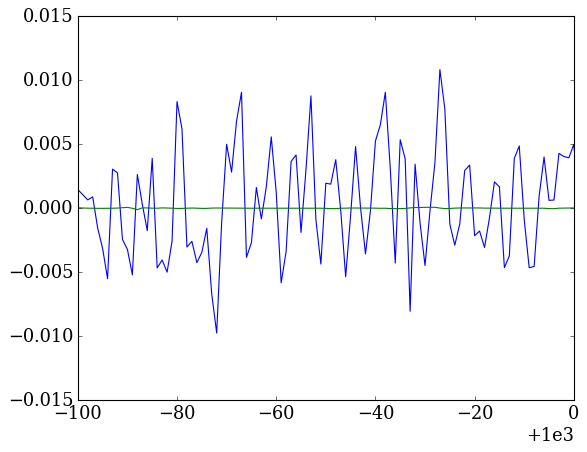

In [39]:
plt.plot(residuals[0, 40])
plt.plot((models_shifted - Bs[i] @ models_shifted)[40])
# plt.plot((ms - Bs[i] @ ms)[70]/2)
plt.xlim(900, 1000)

In [40]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(0, 301, 1)
Vsys_range = np.arange(-100, 101, 1)
RV_range = np.arange(-100, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        model_wave,
        gaussian_filter1d(spectrum, 3),
        # spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 13.553863763809204 seconds


In [48]:
def plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    CCF_Kp_Vsys,
    species,
    Kp,
    Vsys=0,
    RM_mask_size=10,
    plot_slice=False,
    plot_label=False,
    savefig=False,
    file_path=None,
    cmap=cmr.ember,
):
    # Expected value
    CCF_Kp_Vsys = CCF_Kp_Vsys - np.mean(CCF_Kp_Vsys)
    idx = find_nearest_idx(Vsys_range, Vsys)
    mask = np.ones(len(Vsys_range), dtype=bool)
    mask[idx - RM_mask_size : idx + RM_mask_size] = False
    stdev = np.std(CCF_Kp_Vsys[:, mask])
    maxx = (CCF_Kp_Vsys / stdev).max()

    loc = np.where(CCF_Kp_Vsys / stdev == maxx)

    colors = cmr.take_cmap_colors(cmap, 10, cmap_range=(0.1, 0.9), return_fmt="hex")
    if plot_slice:
        fig, axes = plt.subplots(
            2,
            1,
            figsize=(8, 10),
            constrained_layout=True,
            gridspec_kw={"height_ratios": [8, 2]},
        )
        ax1 = axes[0]
        ax2 = axes[1]
        idx = find_nearest_idx(Kp_range, Kp)
        slicee = CCF_Kp_Vsys[idx] / stdev
        ax2.plot(Vsys_range, slicee, c=colors[5])
        ax2.axis(
            [
                np.min(Vsys_range),
                np.max(Vsys_range),
                1.1 * slicee.min(),
                1.1 * slicee.max(),
            ]
        )
        ax2.set_xlabel(r"$\Delta$V$_{sys}$(km/s)")
        ax2.set_ylabel(r"$\Delta$ CCF ($\sigma$)")
        ax2.set_title("Slice at K$_{p}$ = " + str(Kp) + " km/s")
        ax2.axvline(x=Vsys, ls="--", color="black")
    else:
        fig, ax1 = plt.subplots(figsize=(8, 8), constrained_layout=False)
    im = ax1.imshow(
        CCF_Kp_Vsys / stdev,
        extent=[Vsys_range.min(), Vsys_range.max(), Kp_range.min(), Kp_range.max()],
        aspect=len(Vsys_range) / len(Kp_range),
        interpolation="bilinear",
        cmap=cmap,
        origin="lower",
    )
    if plot_label:
        ax1.text(
            0.05,
            0.15,
            species,
            ha="left",
            va="top",
            transform=ax1.transAxes,
            color="white",
            fontsize=32,
        )
    cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
    ax1.axvline(x=Vsys, color="white", ls="--", lw=2)
    ax1.axhline(y=Kp, color="white", ls="--", lw=2)
    ax1.plot(Vsys_range[loc[1]], Kp_range[loc[0]], "xk", ms=15, mew=3)
    ax1.set_xlabel("$\Delta$V$_{sys}$ (km/s)")
    ax1.set_ylabel(r"K$_{p}$ (km/s)")
    ax1.set_title(r"$\Delta$ CCF ($\sigma$)")

    if savefig:
        plt.savefig(file_path)

    return

In [52]:
def plot_CCF_phase_RV(
    phi,
    RV_range,
    CCF_phase_RV,
    species,
    plot_label=False,
    save_path=None,
    cmap=cmr.ember,
):
    for i in range(len(CCF_phase_RV)):
        CCF_phase_RV[i] = CCF_phase_RV[i] - np.mean(CCF_phase_RV[i])
        # CCF_per_phase[i] = CCF_per_phase[i] / stdev
        CCF_phase_RV[i] /= np.std(CCF_phase_RV[i])
    # stdev = np.std(CCF_phase_RV)
    # maxx = (CCF_phase_RV).max()
    fig, ax = plt.subplots(figsize=(10.667, 3), constrained_layout=False)
    im = ax.imshow(
        CCF_phase_RV,
        extent=[RV_range.min(), RV_range.max(), phi.min(), phi.max()],
        aspect="auto",
        interpolation="bilinear",
        cmap=cmap,
        origin="lower",
    )
    if plot_label:
        ax.text(
            0.05,
            0.3,
            species,
            ha="left",
            va="top",
            transform=ax.transAxes,
            color="white",
            fontsize=32,
        )

    cbar = plt.colorbar(im)
    # ax.plot(
    #     np.arange(-180, -50),
    #     (np.arange(-180, -50) + 100) / (200) / (2 * np.pi)
    #     + 0.4,  # phi start from 90 degrees. sin(phi-90) -90 = -phi
    #     "--",
    #     color="red",
    #     alpha=0.5,
    # )
    # plot(V_sys_arr[loc[1]], phi[loc[0]], "xk", ms=7)
    # axis([V_sys_arr.min(), V_sys_arr.max(), phi.min(), phi.max()])
    ax.set_xlabel(r"$\rm{V_p}$ (km/s)")
    ax.set_ylabel(r"$\phi$", rotation=0, labelpad=20)
    ax.set_title(r"$\Delta$ CCF ($\sigma$)")
    if save_path:
        plt.savefig(save_path)
    return

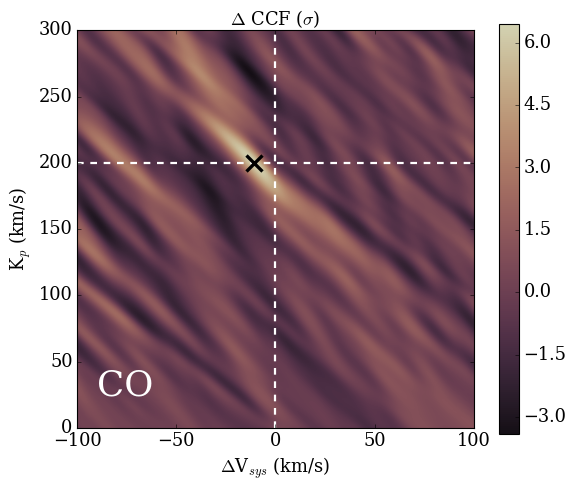

In [53]:
import matplotlib
import POSEIDON.visuals

params = {
    "legend.fontsize": 14,
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize": 16,
}
matplotlib.rcParams.update(params)
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "CO",
    200,
    Vsys=0,
    RM_mask_size=50,
    plot_label=True,
    file_path="./CC_output/WASP77_CCF_CO.pdf",
    savefig=True,
    plot_slice=False,
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
)

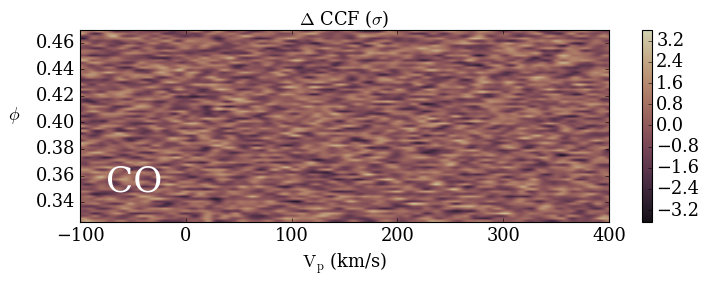

: 

In [54]:
plot_CCF_phase_RV(
    phi,
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0),
    "CO",
    plot_label=True,
    save_path="./CC_output/WASP77_CCF_phase_CO.pdf",
    cmap=cmr.get_sub_cmap("cmr.sepia", 0.1, 0.9),
)